Refernce: Watkins, L. P., Chang, H., & Yang, H. (2006). Quantitative single-molecule conformational distributions: A case study with poly-(L-proline). Journal of Physical Chemistry A, 110(15), 5191–5203. https://doi.org/10.1021/jp055886d

In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, JLD

┌ Info: Precompiling Potential [5d9c1d1b-d707-44ee-860f-8443d6913d0d]
└ @ Base loading.jl:1278
┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{eq}(x)$

In [3]:
k_ref = 0.5 # unit: kcal/mol/angstrom^2
Vref = harmonic_well_k_mean(xref, k_ref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

In [4]:
sum(w0 .* p_eq)

0.9999999999999997

### Part 3: Given knowledge of the estimated trajecotry $\bar{x}(t)$

In [4]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_1.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

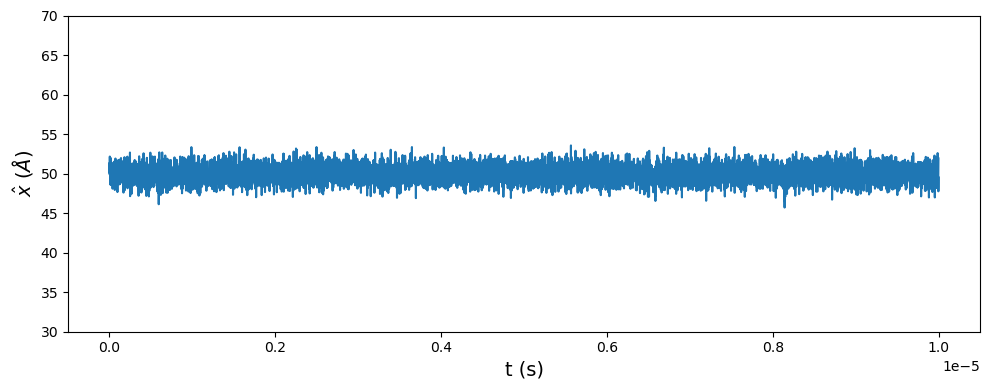

In [11]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,4))

ax.plot(t_record, y_record)
ax.set_ylabel("\$\\hat{x}\$ (\$ \\AA \$)", fontsize=lbfz)
ax.set_xlabel("t (s)", fontsize=lbfz)
ax.set_ylim(30,70)

plt.tight_layout()
plt.show()

### Part 3: Gaussian kernel estimator for $r(x)$
\begin{equation}
\hat{r}(x) = \frac{1}{T} \sum_{i=1}^{N} \Delta t_i k(x;\alpha^2)
\end{equation}
where $\alpha=1$

In [5]:
k_kde = 0.5 # 0.05 # unit: kcal/mol/angstrom^2
σ = 1 / sqrt(2 * k_kde)
r_hat = gaussian_kde(xref, y_record, σ, w0);

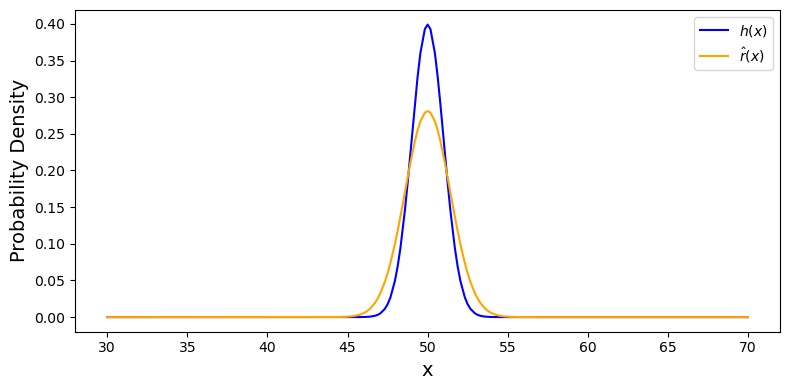

In [25]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, p_eq, color="blue", label="\$h(x)\$")
ax.plot(xref, r_hat, color="orange", label="\$\\hat{r}(x)\$")
ax.set_ylabel("Probability Density", fontsize=lbfz)
ax.set_xlabel("x", fontsize=lbfz)
ax.legend()
#ax.set_ylim(30,70)

plt.tight_layout()
plt.show()

### Part 4: $G(x)=k[\hat{x}(0)-x, \alpha^2]$

In [6]:
x_hat_0 = y_record[1]
xarray = xref .+ (-x_hat_0)
g_of_x = gaussian(xarray[:,1], 0., σ);

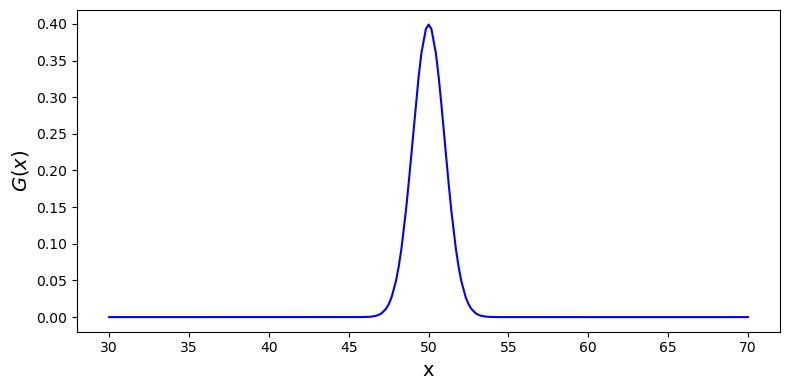

In [35]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, g_of_x, color="blue")
ax.set_ylabel("\$G(x)\$", fontsize=lbfz)
ax.set_xlabel("x", fontsize=lbfz)
#ax.set_ylim(30,70)

plt.tight_layout()
plt.show()

### Part 5: $G(t)=k[\hat{x}(t)-x_2, \alpha^2]$
Set $x_2$

In [7]:
idx = 100 # 1,....,193
x2 = xref[idx]

50.625

In [22]:
idx_array = 1:100:length(t_record)
g_of_t = zeros(length(idx_array))
count = 1
for idx in idx_array
    x_hat_t = y_record[idx]
    g_of_t[count] = gaussian(x_hat_t - x2, 0., σ)
    count += 1
end

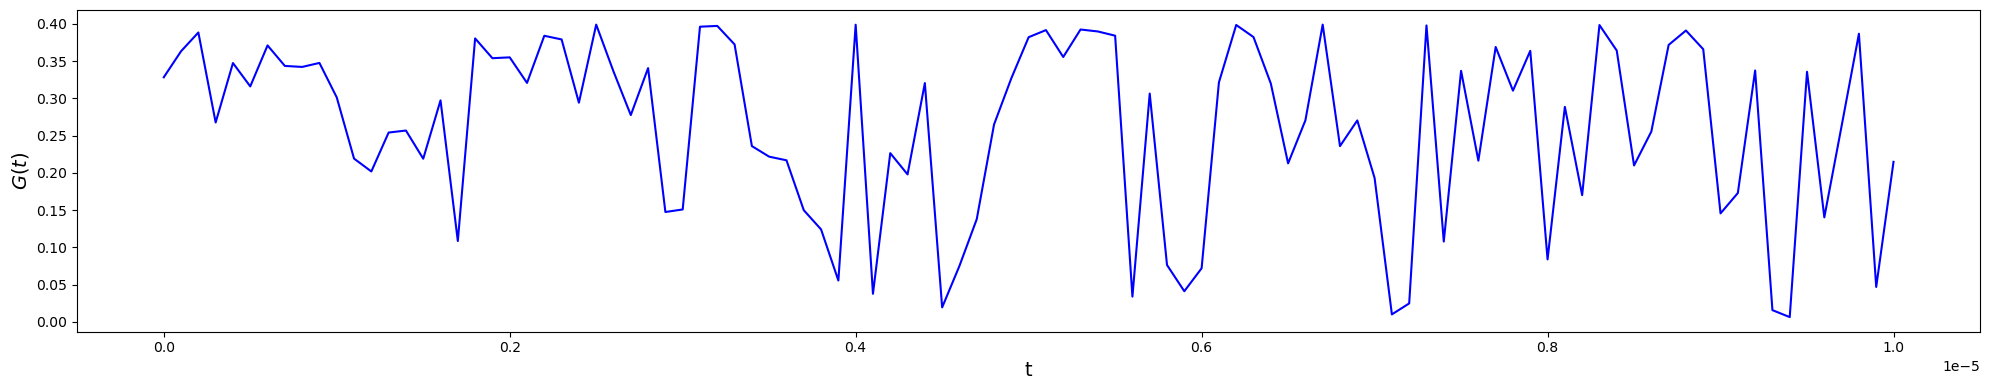

In [24]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,4))

ax.plot(t_record[idx_array], g_of_t, color="blue")
ax.set_ylabel("\$G(t)\$", fontsize=lbfz)
ax.set_xlabel("t", fontsize=lbfz)
#ax.set_ylim(30,70)

plt.tight_layout()
plt.show()